# Melting Point Dataset - Exploratory Data Analysis

This notebook explores the dataset and creates visualizations to understand the relationship between molecular properties and melting point.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from mordred import Calculator, descriptors
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTarget (Tm) statistics:")
print(train_df['Tm'].describe())

Training samples: 2662
Test samples: 666

Target (Tm) statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


## 2. Generate Molecular Descriptors for Visualization

In [4]:
def compute_rdkit_descriptors(smiles_list):
    """Compute RDKit descriptors related to melting point"""
    descriptors_list = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors_list.append({key: np.nan for key in [
                'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
                'NumRotatableBonds', 'NumAromaticRings', 'NumHeavyAtoms',
                'FractionCSP3', 'NumRings', 'NumHeteroatoms', 'MolMR'
            ]})
            continue
            
        desc = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHDonors': Lipinski.NumHDonors(mol),
            'NumHAcceptors': Lipinski.NumHAcceptors(mol),
            'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
            'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'NumHeavyAtoms': Lipinski.HeavyAtomCount(mol),
            'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
            'NumRings': rdMolDescriptors.CalcNumRings(mol),
            'NumHeteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol),
            'MolMR': Descriptors.MolMR(mol),
        }
        descriptors_list.append(desc)
    
    return pd.DataFrame(descriptors_list)

print("Computing RDKit descriptors...")
train_rdkit = compute_rdkit_descriptors(train_df['SMILES'].values)
print(f"RDKit descriptors generated: {train_rdkit.shape[1]}")
train_rdkit.head()

Computing RDKit descriptors...
RDKit descriptors generated: 12


,MolWt,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,NumHeavyAtoms,FractionCSP3,NumRings,NumHeteroatoms,MolMR
0,162.032,2.42120,0.00,0,0,0,0,10,0.50,1,6,19.1360
1,217.271,4.47430,15.79,1,0,0,4,17,0.00,4,1,73.3107
2,160.220,2.36462,17.82,0,2,1,2,12,0.30,2,2,50.1440
3,84.074,0.09430,37.30,1,1,0,0,6,0.25,0,2,21.0858
4,118.245,2.49490,0.00,1,1,3,0,7,1.00,0,1,37.9730


In [5]:
def compute_mordred_descriptors(smiles_list):
    """Compute Mordred descriptors that work for all molecules"""
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    
    calc = Calculator(descriptors, ignore_3D=True)
    print(f"Calculating {len(calc.descriptors)} Mordred descriptors...")
    df = calc.pandas(mols)
    
    df = df.apply(pd.to_numeric, errors='coerce')
    valid_cols = df.columns[df.notna().all()].tolist()
    df_clean = df[valid_cols]
    df_clean = df_clean.loc[:, df_clean.std() > 0]
    
    print(f"Valid Mordred descriptors: {df_clean.shape[1]}")
    return df_clean

print("Computing Mordred descriptors...")
train_mordred = compute_mordred_descriptors(train_df['SMILES'].values)
print(f"\nMordred descriptors shape: {train_mordred.shape}")

Computing Mordred descriptors...
Calculating 1613 Mordred descriptors...
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophysical Property Melting Point\venv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\tkasiror\Desktop\Thermophy

---
## 3. Visualizations
---

### Visualization 1: Distribution of Melting Points

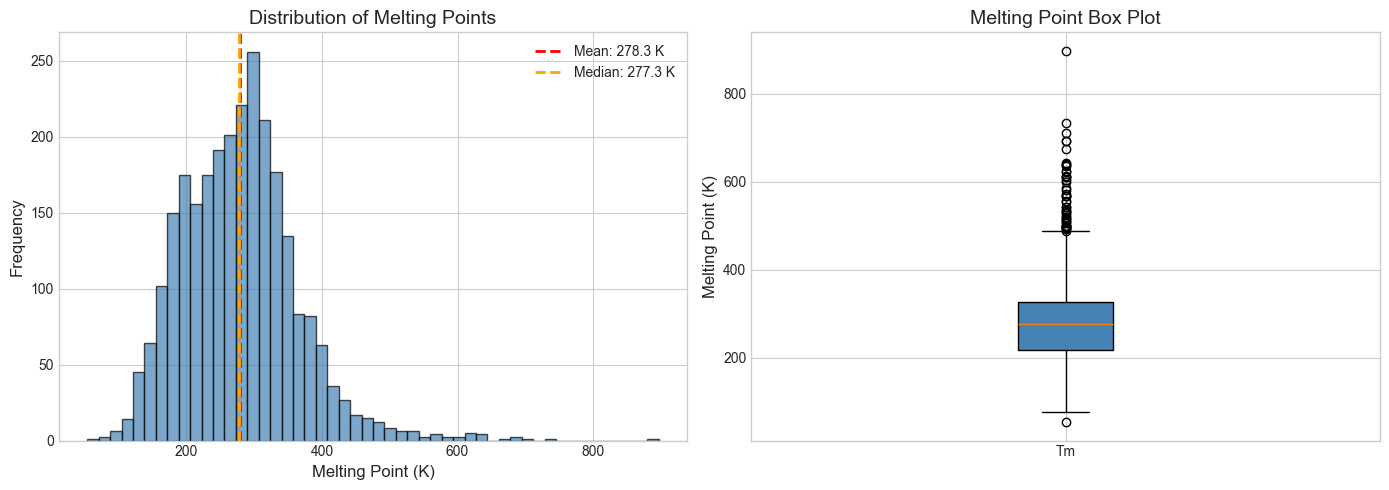

Saved: viz_1_melting_point_distribution.png


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['Tm'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(train_df['Tm'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {train_df['Tm'].mean():.1f} K")
axes[0].axvline(train_df['Tm'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {train_df['Tm'].median():.1f} K")
axes[0].set_xlabel('Melting Point (K)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Melting Points', fontsize=14)
axes[0].legend()

# Box plot
bp = axes[1].boxplot(train_df['Tm'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
axes[1].set_ylabel('Melting Point (K)', fontsize=12)
axes[1].set_title('Melting Point Box Plot', fontsize=14)
axes[1].set_xticklabels(['Tm'])

plt.tight_layout()
plt.savefig('viz_1_melting_point_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_1_melting_point_distribution.png")

### Visualization 2: Correlation Matrix of Key Descriptors

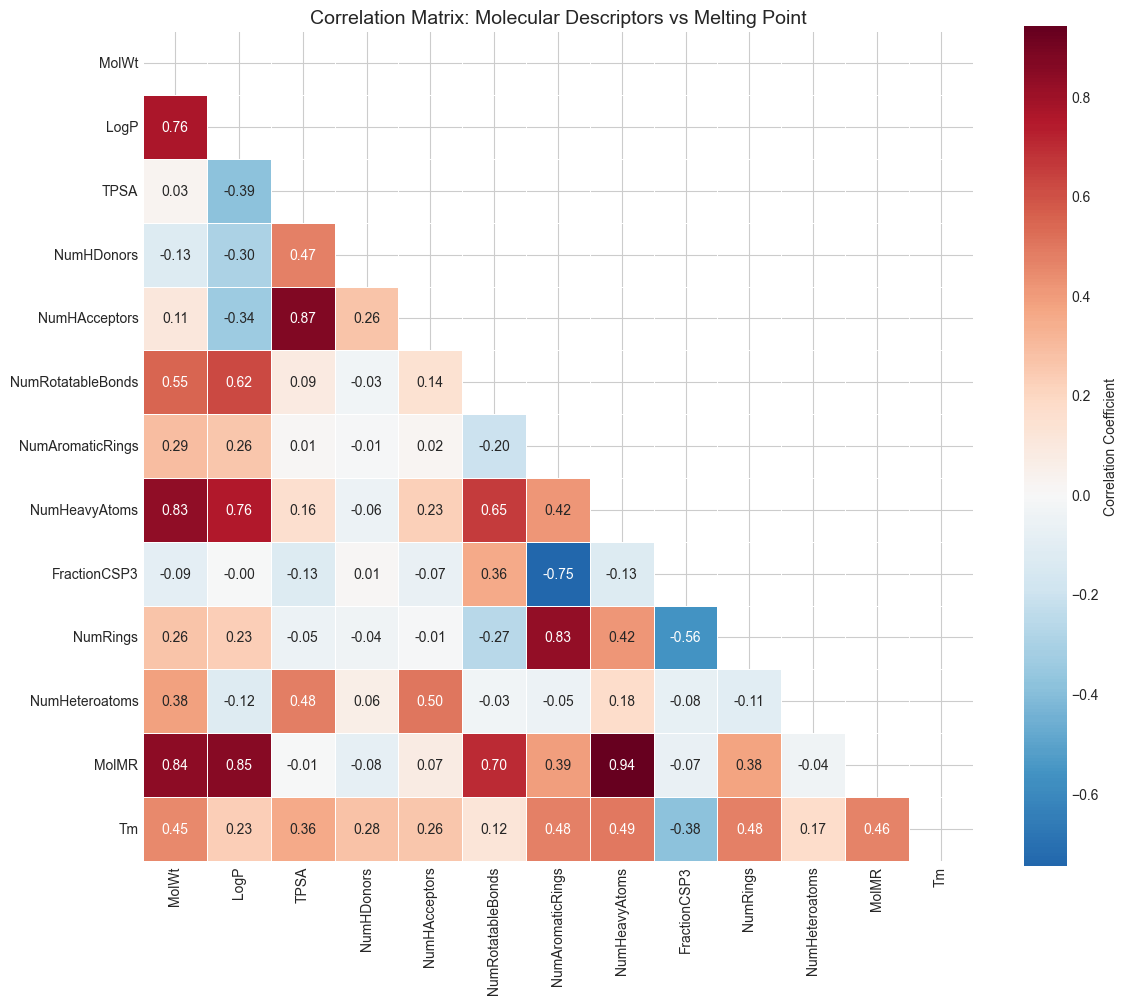

Saved: viz_2_correlation_matrix.png

Correlations with Melting Point (Tm):
NumHeavyAtoms        0.494154
NumRings             0.477688
NumAromaticRings     0.476362
MolMR                0.460410
MolWt                0.447791
FractionCSP3        -0.379497
TPSA                 0.357722
NumHDonors           0.278779
NumHAcceptors        0.257394
LogP                 0.234184
NumHeteroatoms       0.169689
NumRotatableBonds    0.121710
Name: Tm, dtype: float64


In [7]:
key_descriptors = ['MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 
                   'NumRotatableBonds', 'NumAromaticRings', 'NumHeavyAtoms',
                   'FractionCSP3', 'NumRings', 'NumHeteroatoms', 'MolMR']

corr_df = train_rdkit[key_descriptors].copy()
corr_df['Tm'] = train_df['Tm'].values
corr_matrix = corr_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix: Molecular Descriptors vs Melting Point', fontsize=14)

plt.tight_layout()
plt.savefig('viz_2_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_2_correlation_matrix.png")

print("\nCorrelations with Melting Point (Tm):")
tm_corr = corr_matrix['Tm'].drop('Tm').sort_values(key=abs, ascending=False)
print(tm_corr)

### Visualization 3: Scatter Plots - Top Correlated Descriptors vs Melting Point

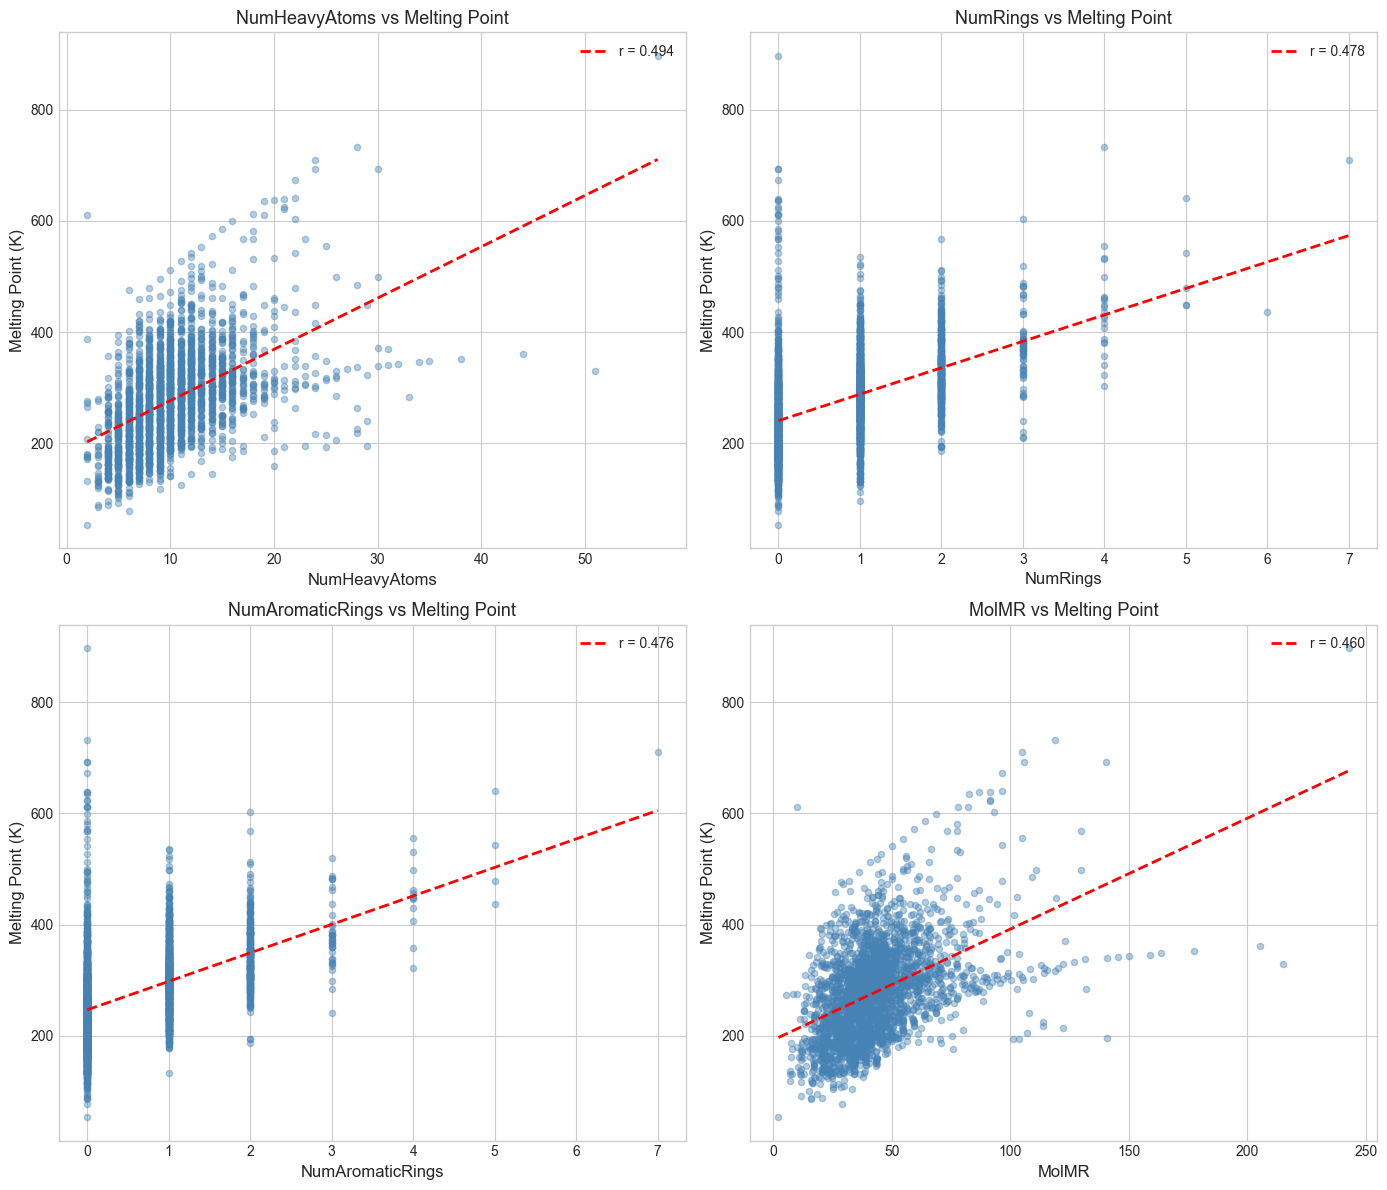

Saved: viz_3_scatter_top_descriptors.png


In [8]:
top_descriptors = tm_corr.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, desc in enumerate(top_descriptors):
    ax = axes[i]
    corr_val = tm_corr[desc]
    
    ax.scatter(train_rdkit[desc], train_df['Tm'], alpha=0.4, s=20, c='steelblue')
    
    # Trend line
    z = np.polyfit(train_rdkit[desc].dropna(), train_df['Tm'].loc[train_rdkit[desc].notna()], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train_rdkit[desc].min(), train_rdkit[desc].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r = {corr_val:.3f}')
    
    ax.set_xlabel(desc, fontsize=12)
    ax.set_ylabel('Melting Point (K)', fontsize=12)
    ax.set_title(f'{desc} vs Melting Point', fontsize=13)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('viz_3_scatter_top_descriptors.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_3_scatter_top_descriptors.png")

### Visualization 4: Melting Point by Molecular Properties (Box Plots)

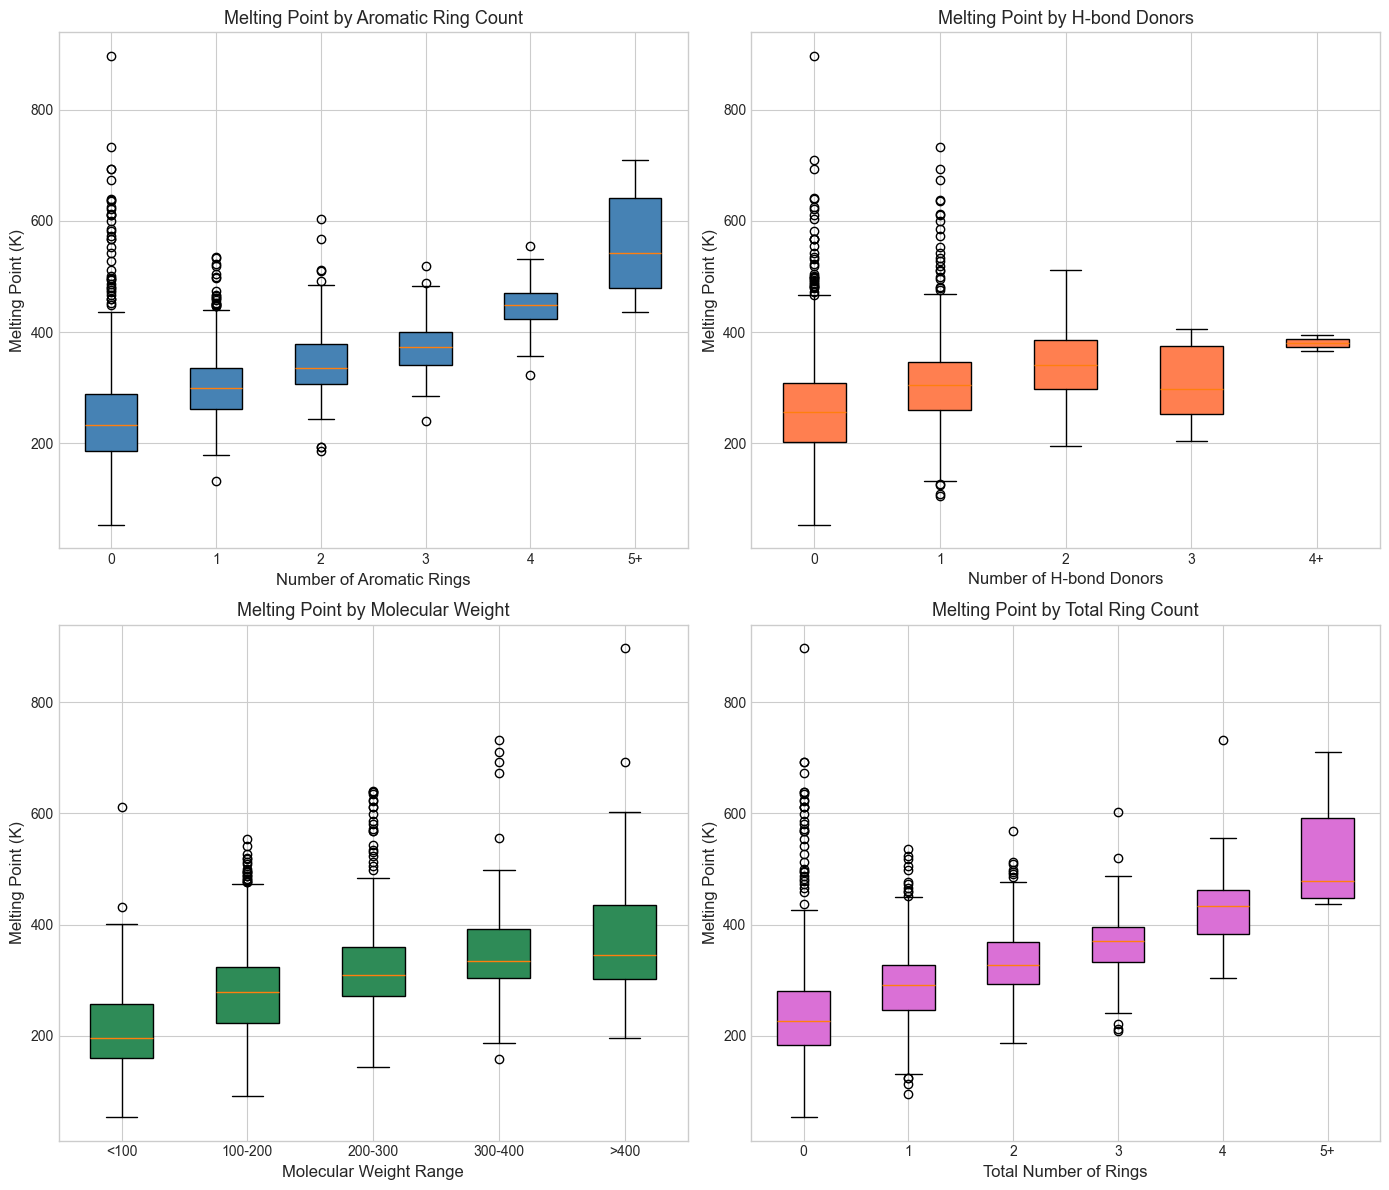

Saved: viz_4_melting_point_by_properties.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. By Number of Aromatic Rings
ax = axes[0, 0]
ring_data = train_rdkit['NumAromaticRings'].clip(upper=5)
data_by_ring = [train_df['Tm'][ring_data == i] for i in range(6)]
bp = ax.boxplot(data_by_ring, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
ax.set_xticklabels(['0', '1', '2', '3', '4', '5+'])
ax.set_xlabel('Number of Aromatic Rings', fontsize=12)
ax.set_ylabel('Melting Point (K)', fontsize=12)
ax.set_title('Melting Point by Aromatic Ring Count', fontsize=13)

# 2. By H-bond Donors
ax = axes[0, 1]
hd_data = train_rdkit['NumHDonors'].clip(upper=4)
data_by_hd = [train_df['Tm'][hd_data == i] for i in range(5)]
bp = ax.boxplot(data_by_hd, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('coral')
ax.set_xticklabels(['0', '1', '2', '3', '4+'])
ax.set_xlabel('Number of H-bond Donors', fontsize=12)
ax.set_ylabel('Melting Point (K)', fontsize=12)
ax.set_title('Melting Point by H-bond Donors', fontsize=13)

# 3. By Molecular Weight bins
ax = axes[1, 0]
mw_bins = pd.cut(train_rdkit['MolWt'], bins=[0, 100, 200, 300, 400, 1000], 
                 labels=['<100', '100-200', '200-300', '300-400', '>400'])
data_by_mw = [train_df['Tm'][mw_bins == label] for label in ['<100', '100-200', '200-300', '300-400', '>400']]
bp = ax.boxplot(data_by_mw, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('seagreen')
ax.set_xticklabels(['<100', '100-200', '200-300', '300-400', '>400'])
ax.set_xlabel('Molecular Weight Range', fontsize=12)
ax.set_ylabel('Melting Point (K)', fontsize=12)
ax.set_title('Melting Point by Molecular Weight', fontsize=13)

# 4. By Total Rings
ax = axes[1, 1]
ring_total = train_rdkit['NumRings'].clip(upper=5)
data_by_rings = [train_df['Tm'][ring_total == i] for i in range(6)]
bp = ax.boxplot(data_by_rings, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('orchid')
ax.set_xticklabels(['0', '1', '2', '3', '4', '5+'])
ax.set_xlabel('Total Number of Rings', fontsize=12)
ax.set_ylabel('Melting Point (K)', fontsize=12)
ax.set_title('Melting Point by Total Ring Count', fontsize=13)

plt.tight_layout()
plt.savefig('viz_4_melting_point_by_properties.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_4_melting_point_by_properties.png")

### Visualization 5: Top 20 Mordred Descriptors Correlated with Melting Point

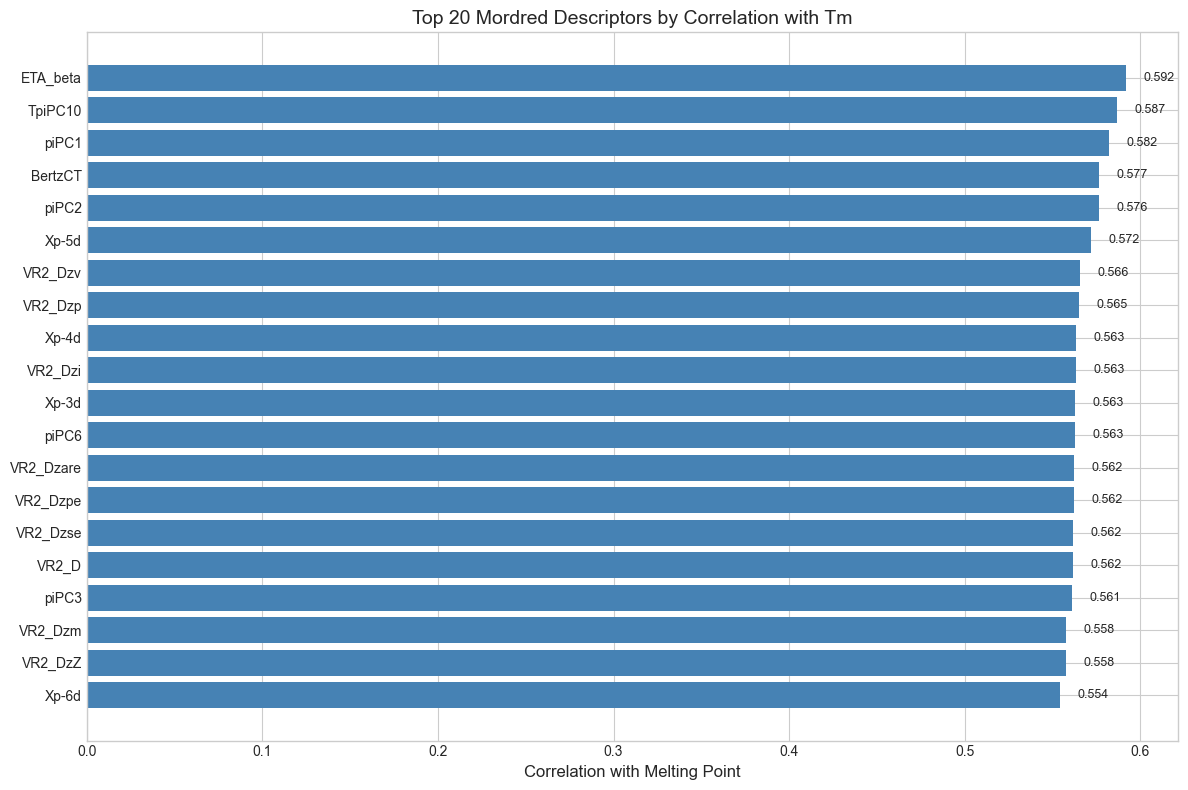

Saved: viz_5_top_mordred_correlations.png

Top 20 Mordred descriptors correlated with Tm:
  ETA_beta: 0.5920
  TpiPC10: 0.5866
  piPC1: 0.5824
  BertzCT: 0.5765
  piPC2: 0.5765
  Xp-5d: 0.5718
  VR2_Dzv: 0.5659
  VR2_Dzp: 0.5653
  Xp-4d: 0.5635
  VR2_Dzi: 0.5634
  Xp-3d: 0.5627
  piPC6: 0.5627
  VR2_Dzare: 0.5623
  VR2_Dzpe: 0.5620
  VR2_Dzse: 0.5618
  VR2_D: 0.5618
  piPC3: 0.5614
  VR2_Dzm: 0.5579
  VR2_DzZ: 0.5577
  Xp-6d: 0.5541


In [10]:
mordred_corr = train_mordred.corrwith(train_df['Tm']).dropna()
mordred_corr_sorted = mordred_corr.abs().sort_values(ascending=False)

top_20_mordred = mordred_corr_sorted.head(20).index.tolist()
top_20_corr = mordred_corr[top_20_mordred]

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['steelblue' if x > 0 else 'coral' for x in top_20_corr]
bars = ax.barh(range(len(top_20_corr)), top_20_corr.values, color=colors)
ax.set_yticks(range(len(top_20_corr)))
ax.set_yticklabels(top_20_corr.index)
ax.set_xlabel('Correlation with Melting Point', fontsize=12)
ax.set_title('Top 20 Mordred Descriptors by Correlation with Tm', fontsize=14)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, top_20_corr.values)):
    ax.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
            va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('viz_5_top_mordred_correlations.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: viz_5_top_mordred_correlations.png")

print("\nTop 20 Mordred descriptors correlated with Tm:")
for desc, corr in zip(top_20_mordred, top_20_corr.values):
    print(f"  {desc}: {corr:.4f}")

## Summary

### Key Findings:
1. **Melting Point Distribution**: The target variable shows a roughly normal distribution with mean ~278 K
2. **Molecular Weight**: Positive correlation with melting point - larger molecules tend to have higher Tm
3. **Aromatic Rings**: More aromatic rings generally increase melting point (pi-stacking)
4. **H-bond Donors**: More hydrogen bond donors increase melting point (stronger intermolecular forces)
5. **TPSA & Heteroatoms**: Polar molecules tend to have higher melting points

### Generated Visualizations:
- `viz_1_melting_point_distribution.png`
- `viz_2_correlation_matrix.png`
- `viz_3_scatter_top_descriptors.png`
- `viz_4_melting_point_by_properties.png`
- `viz_5_top_mordred_correlations.png`